# Imports

In [1]:
import pandas as pd
import numpy as np
import catboost as cb
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV
from scipy.stats.distributions import expon
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
import os
import glob
import re
import h2o
import tqdm
import pickle

%matplotlib notebook
rng = np.random.RandomState(42)

In [2]:
from autoxgb import AutoXGB

# Functions

In [3]:
def look_at_anti_dist(all_ASR, col_name, col_order=None):
    col_dist = all_ASR.groupby(by='antibiotic_name')[col_name].apply(lambda x: x.value_counts()).reset_index()
    col_dist.columns = ['antibiotic_name', col_name, 'count']
    order = col_dist.groupby(by='antibiotic_name')['count'].apply(sum).sort_values().index
    col_dist = pd.pivot_table(col_dist, values='count', index=['antibiotic_name'],
                    columns=[col_name], aggfunc=np.sum).fillna(0)
    if col_order is not None:
        col_dist = col_dist[col_order]
    ax = col_dist.loc[order].plot.barh(stacked=True, rot=0, figsize=(20,15))
    plt.title('Distribution of ' + col_name+' for each anti-biotics')
    plt.ylabel('antibiotics')
    plt.xlabel('# of measurements')
    plt.legend(loc='lower right')

In [4]:
def print_anti_measure(all_ASR, anti_index):
    anti = all_ASR['antibiotic_name'].value_counts().index[anti_index]
    anti_MIC = all_ASR[all_ASR['antibiotic_name'] == anti]
    anti_MIC['measurement'] = anti_MIC['measurement'].apply(np.log2)
    low = anti_MIC['measurement'].min().round()
    high = anti_MIC['measurement'].max().round()
    hist_range = np.arange(low-0.5, high+1, 1)
    bins_count = pd.DataFrame(anti_MIC.groupby(by='measurement_sign')['measurement'].apply(lambda x: np.histogram(x, bins=hist_range)[0]))
    bins_count = bins_count.merge(pd.DataFrame({'fill': [np.zeros(len(hist_range)-1)]}, index=['=', '<=', '>=', '<', '>']), left_index=True, right_index=True, how='right')
    bins_count['measurement'].fillna(bins_count['fill'], inplace=True)
    pd.DataFrame(bins_count['measurement'].tolist(), index= bins_count.index, columns=hist_range[:-1]+0.5).T.plot.bar(stacked=True)
    plt.title(anti)
    plt.xlabel('log2(mg//L)')
    plt.ylabel('#')


In [61]:
def get_filtered_data(
    data = 'tot_filtered_data.csv', 
    features = 'final_features',
    ASR_data = 'filtered_ASR_data.csv', 
    species_sep = True, 
    species_filter_index=0, 
    naive=True, 
    test_range=False, 
    antibiotic_index=0,
    task='regression', 
    strip_range_train=False,
    distance_range_train=False,
    range_moved=5,
):
    data = pd.read_csv('../resources/'+data)
    with open("../resources/"+ features, "rb") as fp:
        features = pickle.load(fp)
    ASR_data = pd.read_csv('../resources/'+ASR_data)
    
    
    
    species2merge = data[['unique_id', 'species_fam']]
    filtered_ASR = ASR_data.drop('species_fam', axis=1).merge(species2merge, on='unique_id')
    filtered_ASR.set_index('unique_id', inplace=True)
    filtered_ASR = filtered_ASR[filtered_ASR['units']=='mg/L']
    data.set_index('unique_id', inplace=True)
    data.drop(['Unnamed: 0', 'species_fam', 'run_id', 'biosample_id'], axis=1, inplace=True)
            
    if species_sep:
        species = filtered_ASR['species_fam'].value_counts().reset_index()['index'].iloc[species_filter_index]
        filtered_ASR = filtered_ASR[filtered_ASR['species_fam'] == species]
    
    if test_range:
        test_ASR = filtered_ASR[filtered_ASR['measurement_sign']!='=']    
        
    if naive:
        filtered_ASR = filtered_ASR[filtered_ASR['measurement_sign']=='=']
    
    anti_list = filtered_ASR['antibiotic_name'].value_counts().index.values
    label = anti_list[antibiotic_index]
    
    y = data.loc[filtered_ASR[filtered_ASR['antibiotic_name'] == label].index][label]
    
    if naive:
        if task == 'regression':
            y = y.apply(lambda x: float(x.split(' ')[1]))
        elif task == 'classification':
            y = y.apply(lambda x: str(x.split(' ')[1]))
            
    else:
        if task == 'classification':
            y=y
        elif task == 'regression':
            if strip_range_train:
                y = y.apply(lambda x: float(x.split(' ')[1]))
            elif distance_range_train:
                signs = y.apply(lambda x: str(x.split(' ')[0]))
                y = y.apply(lambda x: float(x.split(' ')[1]))
                y = y.mask(np.logical_or(signs == '<', signs == '<='), y-range_moved)
                y = y.mask(np.logical_or(signs == '>', signs == '>='), y+range_moved)
            else:
                print('regression not in the naive approach is not implemented yet.') 
        
            
    
    if test_range:
        range_test_values = data.loc[test_ASR[test_ASR['antibiotic_name'] == label].index][label]
        range_labels = pd.DataFrame({
            'values':[],
            'direction': [],
        })
        range_labels['values'] = range_test_values.apply(lambda x: float(x.split(' ')[1]))
        range_labels['direction'] = range_test_values.apply(lambda x: x.split(' ')[0].replace('=', ''))
    else:
        range_labels = None
        X_range = None
        
    
    X = data.loc[filtered_ASR[filtered_ASR['antibiotic_name'] == label].index][features]
    X.dropna(axis=1, how='all', inplace=True)
    X.fillna(0, inplace=True)
    
    if test_range:
        train_features = X.columns.values
        X_range = data.loc[test_ASR[test_ASR['antibiotic_name'] == label].index][train_features]
        X_range.fillna(0, inplace=True)
    
    return X, y, X_range, range_labels, list(train_features), label

# Load data

## DataSet

In [19]:
data = pd.read_csv('../resources/tot_filtered_data.csv')
with open("../resources/final_labels", "rb") as fp:
    labels = pickle.load(fp)
with open("../resources/final_features", "rb") as fp:
    features = pickle.load(fp)
    

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (4,5,6,7,8,10,12,15,18,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,1156,1157,1158,1159,1160,1161,1162,1163,1164) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Meta Data

In [20]:
ASR_data = pd.read_csv('../resources/filtered_ASR_data.csv')

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [22]:
species2merge = data[['unique_id', 'species_fam']]
filtered_ASR = ASR_data.drop('species_fam', axis=1).merge(species2merge, on='unique_id')

# Exploration

<IPython.core.display.Javascript object>


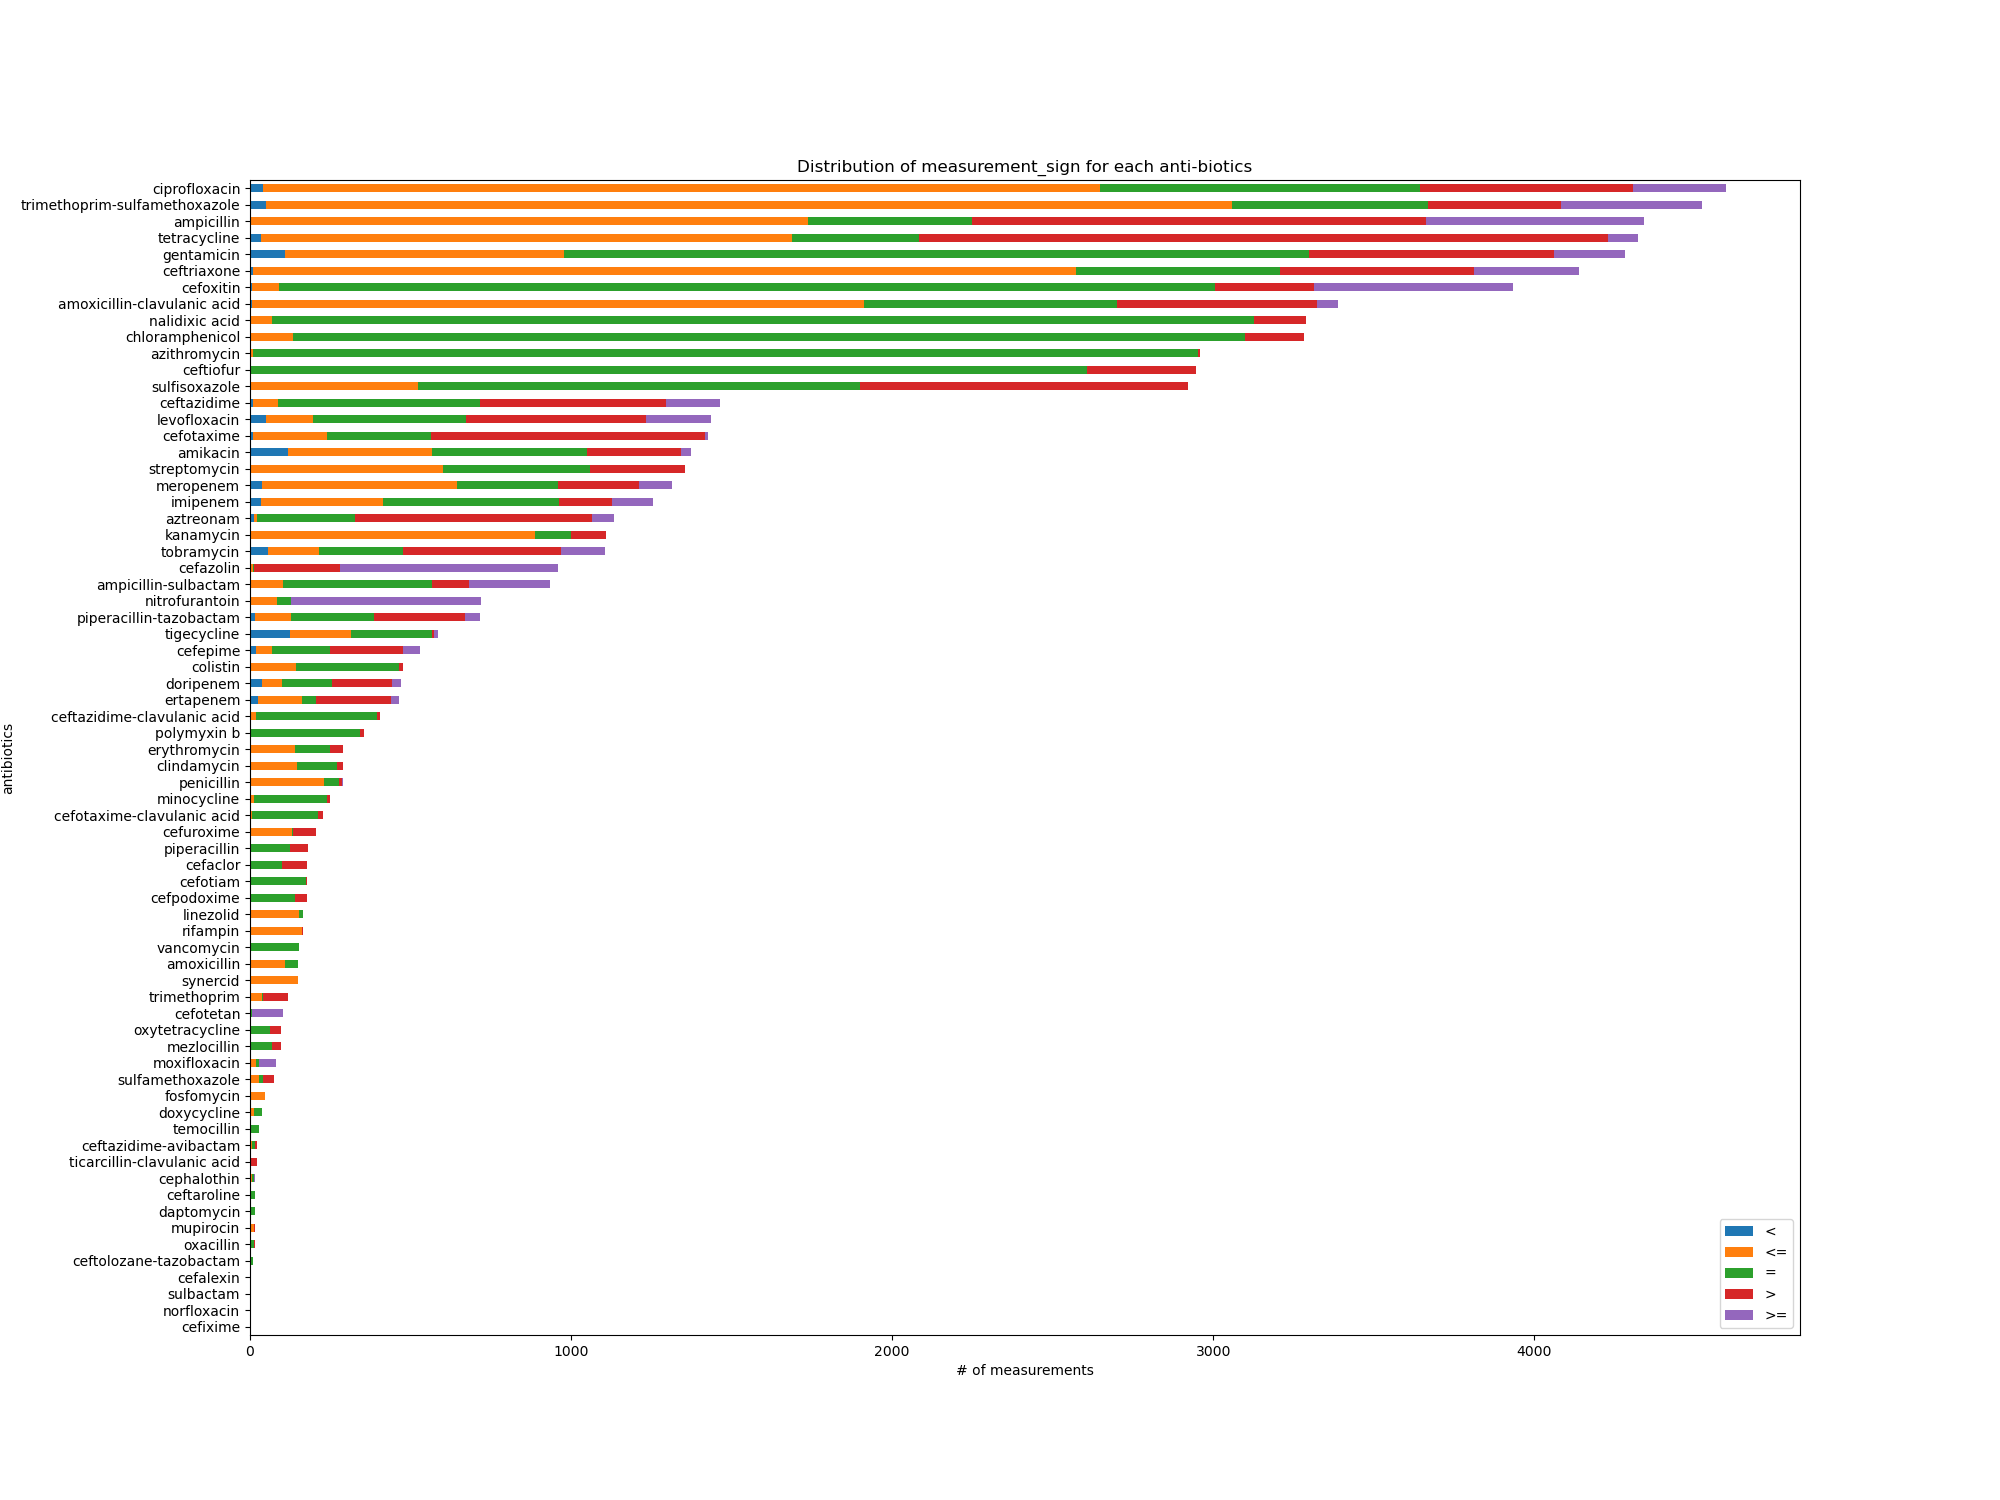

In [8]:
look_at_anti_dist(filtered_ASR, 'measurement_sign', col_order=None)

<IPython.core.display.Javascript object>


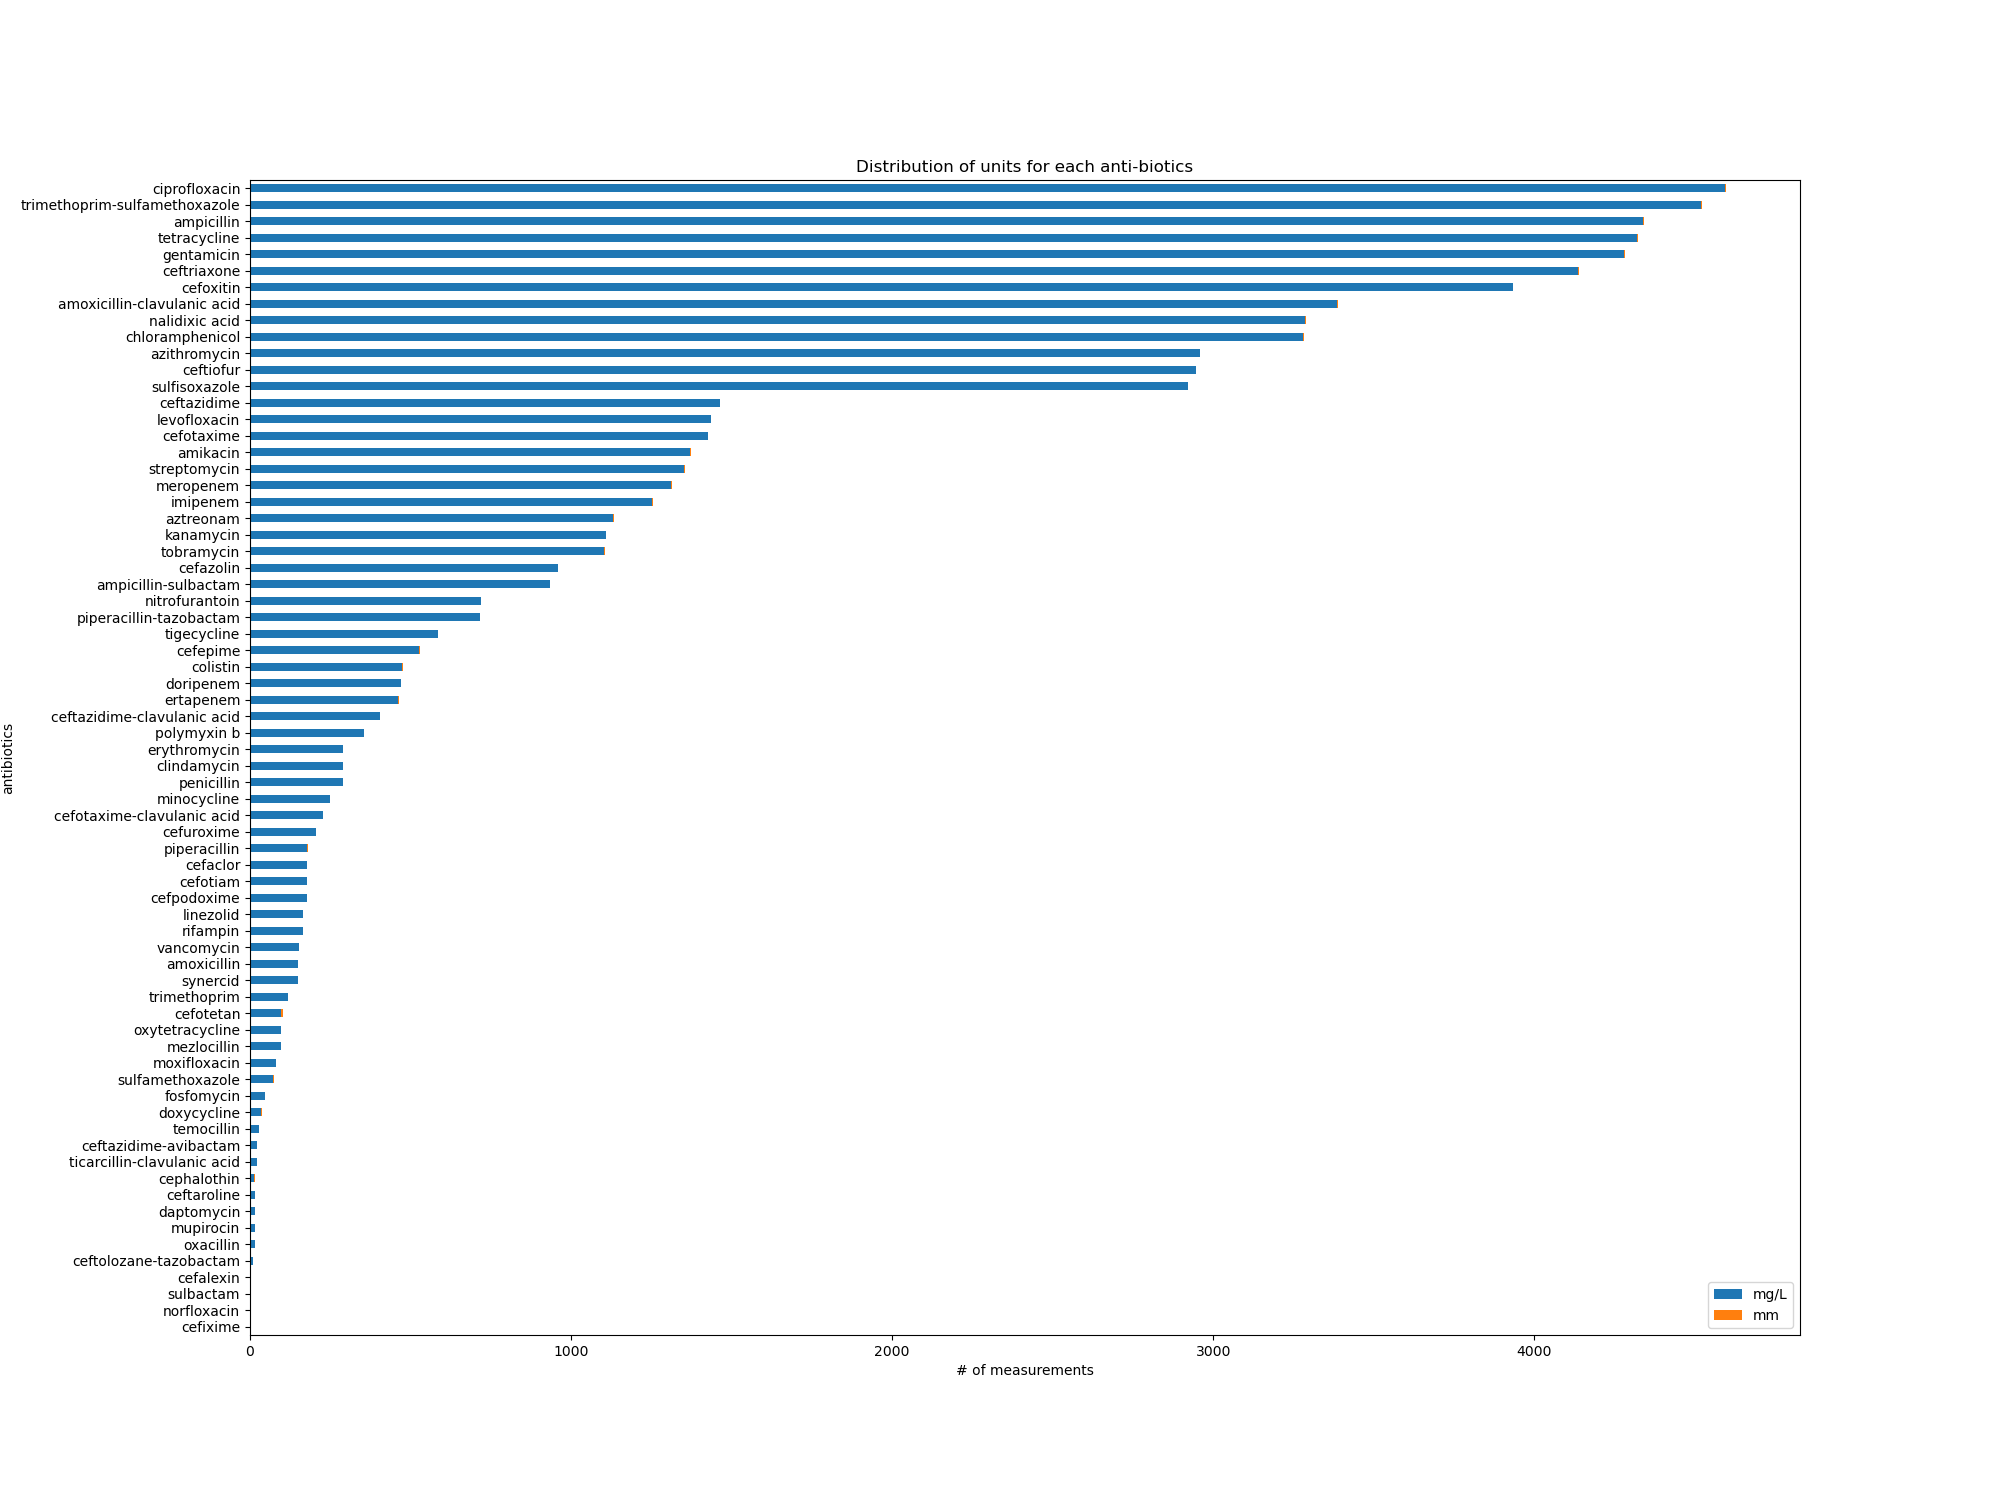

In [8]:
look_at_anti_dist(filtered_ASR, 'units', col_order=None)

<IPython.core.display.Javascript object>


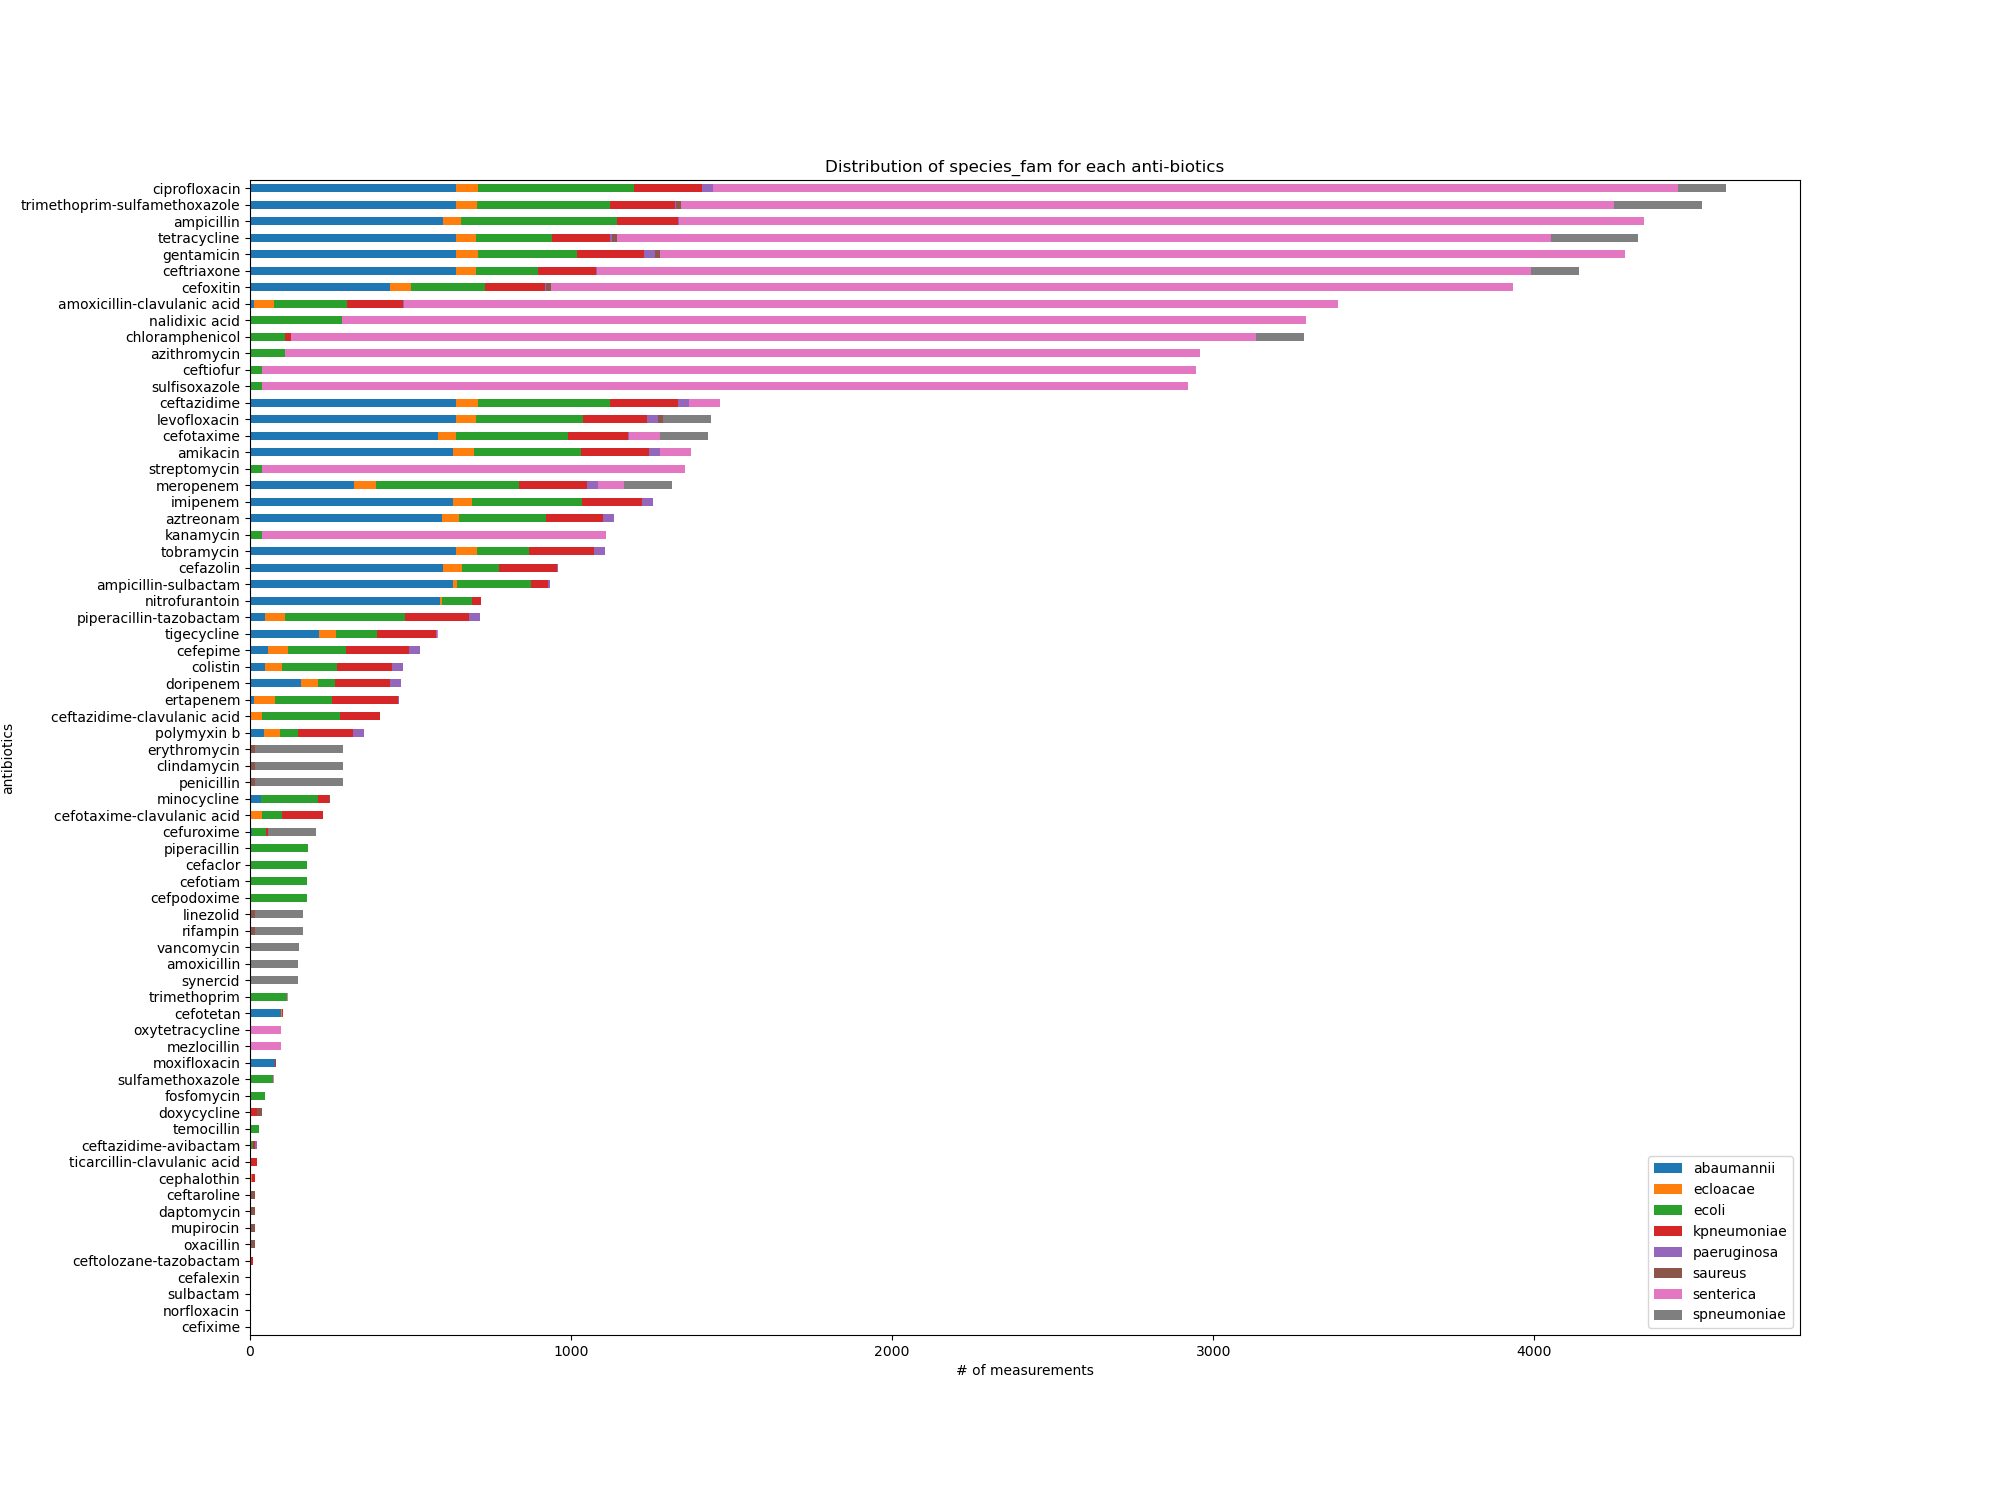

In [9]:
look_at_anti_dist(filtered_ASR, 'species_fam', col_order=None)

# Cleaning

In [23]:
filtered_ASR['unique_id'].describe()

count                72352
unique                4736
top       SAMN04448226VAMP
freq                    29
Name: unique_id, dtype: object

## bad units

In [24]:
filtered_ASR = filtered_ASR[filtered_ASR['units']=='mg/L']

In [25]:
filtered_ASR['unique_id'].describe()

count                72280
unique                4734
top       SAMN04448226VAMP
freq                    29
Name: unique_id, dtype: object

## Filter species

<IPython.core.display.Javascript object>


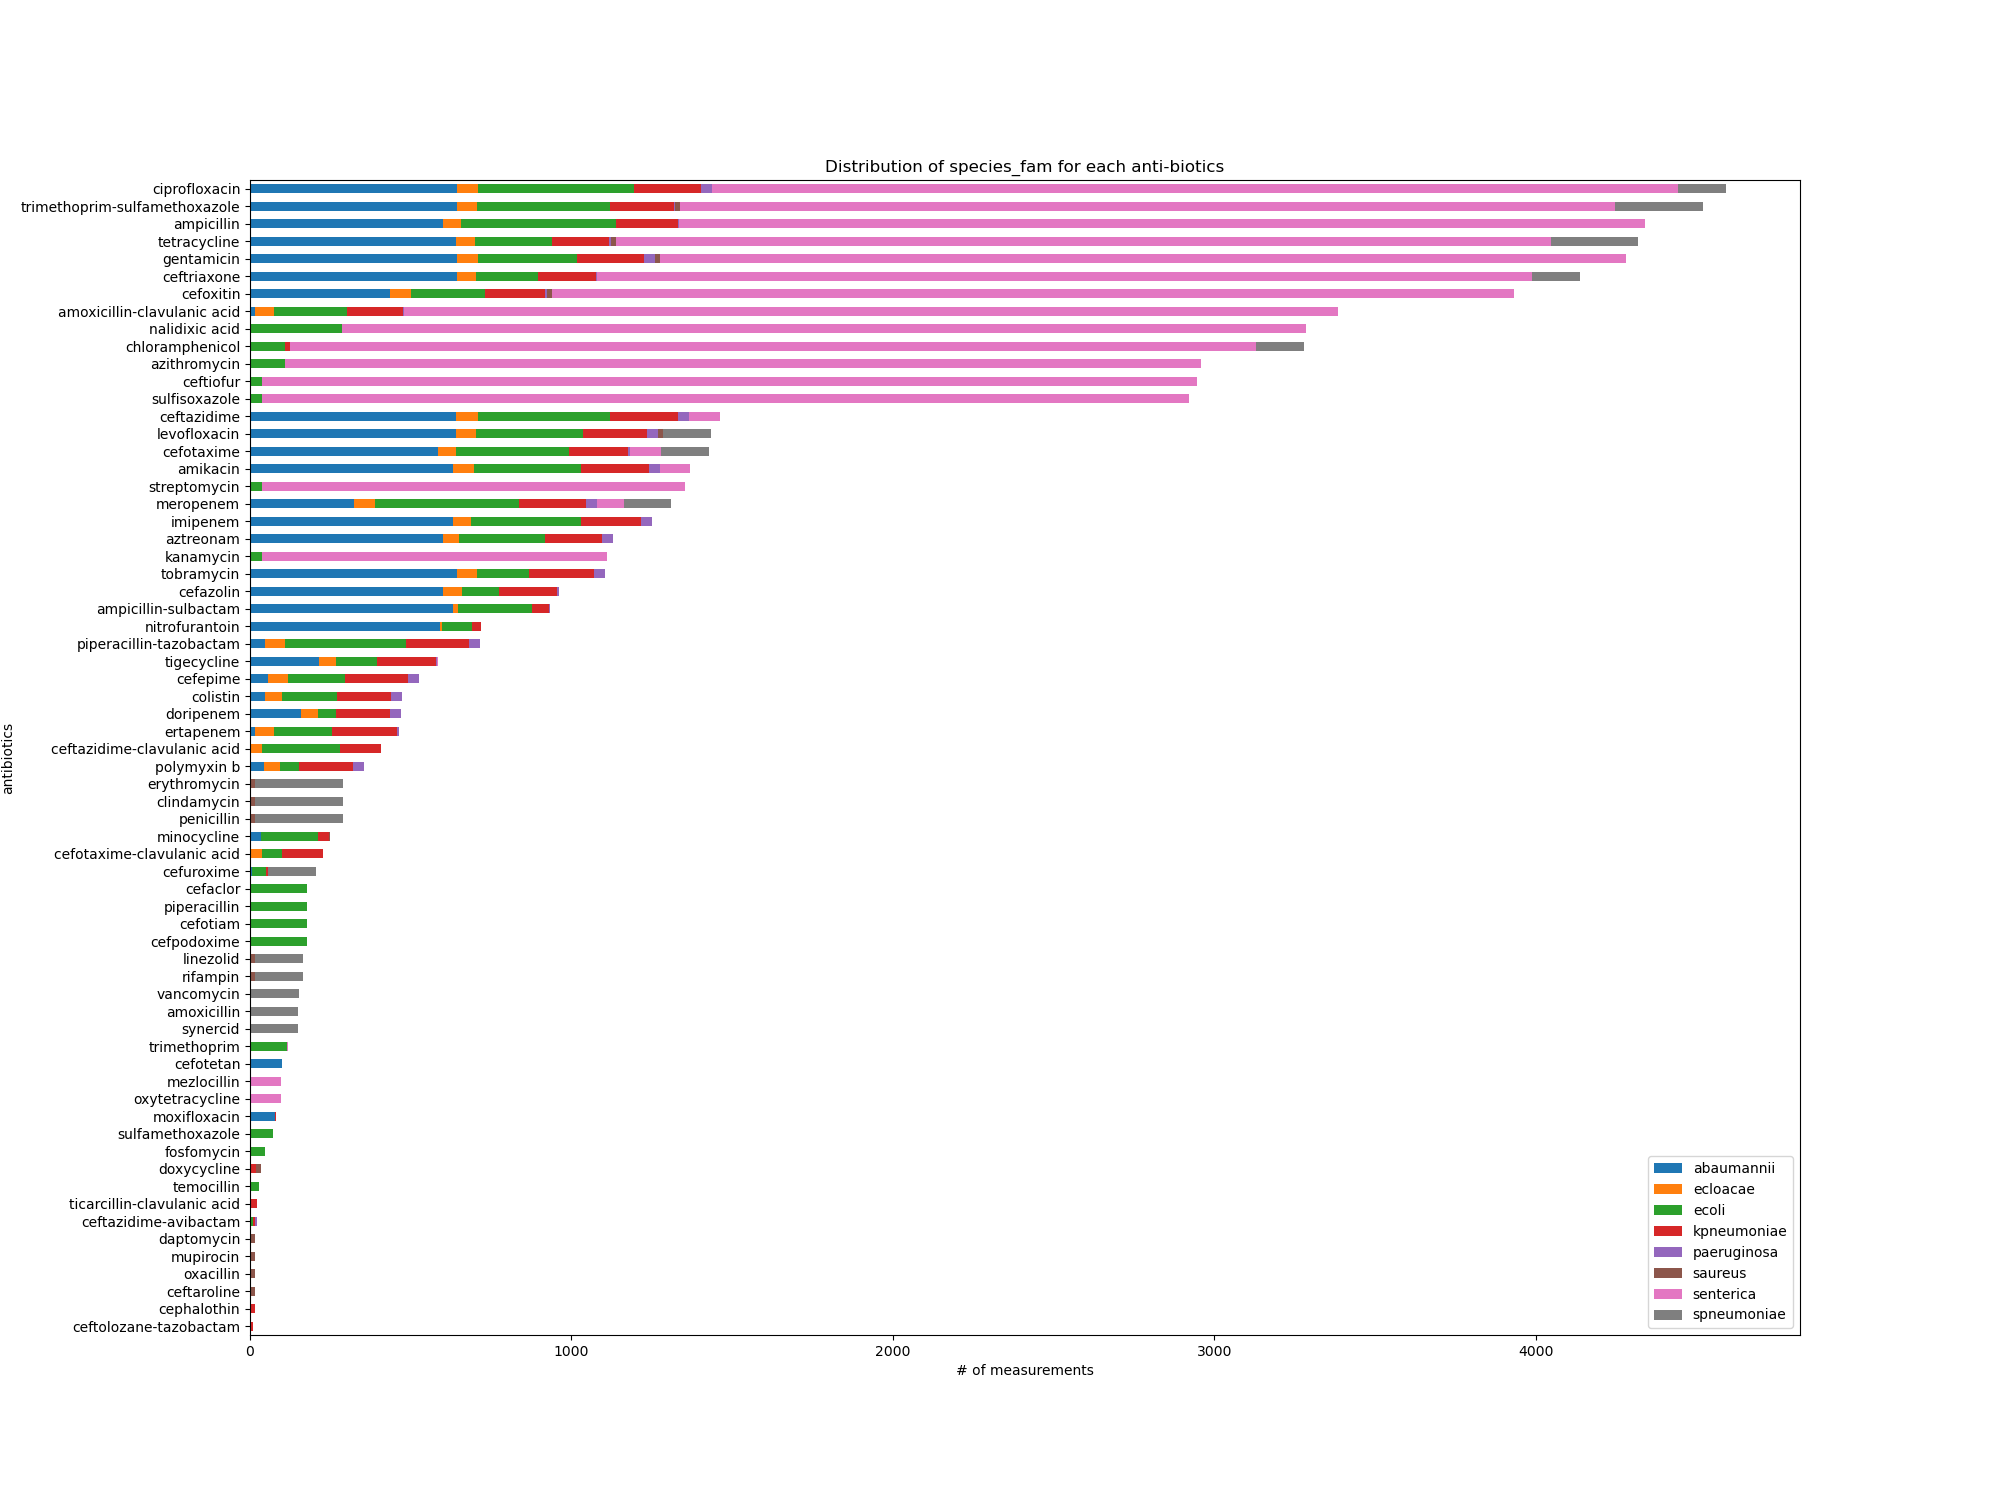

In [29]:
look_at_anti_dist(filtered_ASR, 'species_fam', col_order=None)

In [26]:
species = filtered_ASR['species_fam'].value_counts().reset_index()['index'].iloc[0]

In [27]:
filtered_ASR = filtered_ASR[filtered_ASR['species_fam'] == species]
# look_at_anti_dist(filtered_ASR, 'species_fam')

## filter range sighs

In [11]:
# filtered_ASR = filtered_ASR[filtered_ASR['measurement_sign']=='=']

In [28]:
filtered_ASR['unique_id'].describe()

count                41239
unique                3005
top       SAMN02699187VAMP
freq                    15
Name: unique_id, dtype: object

<IPython.core.display.Javascript object>


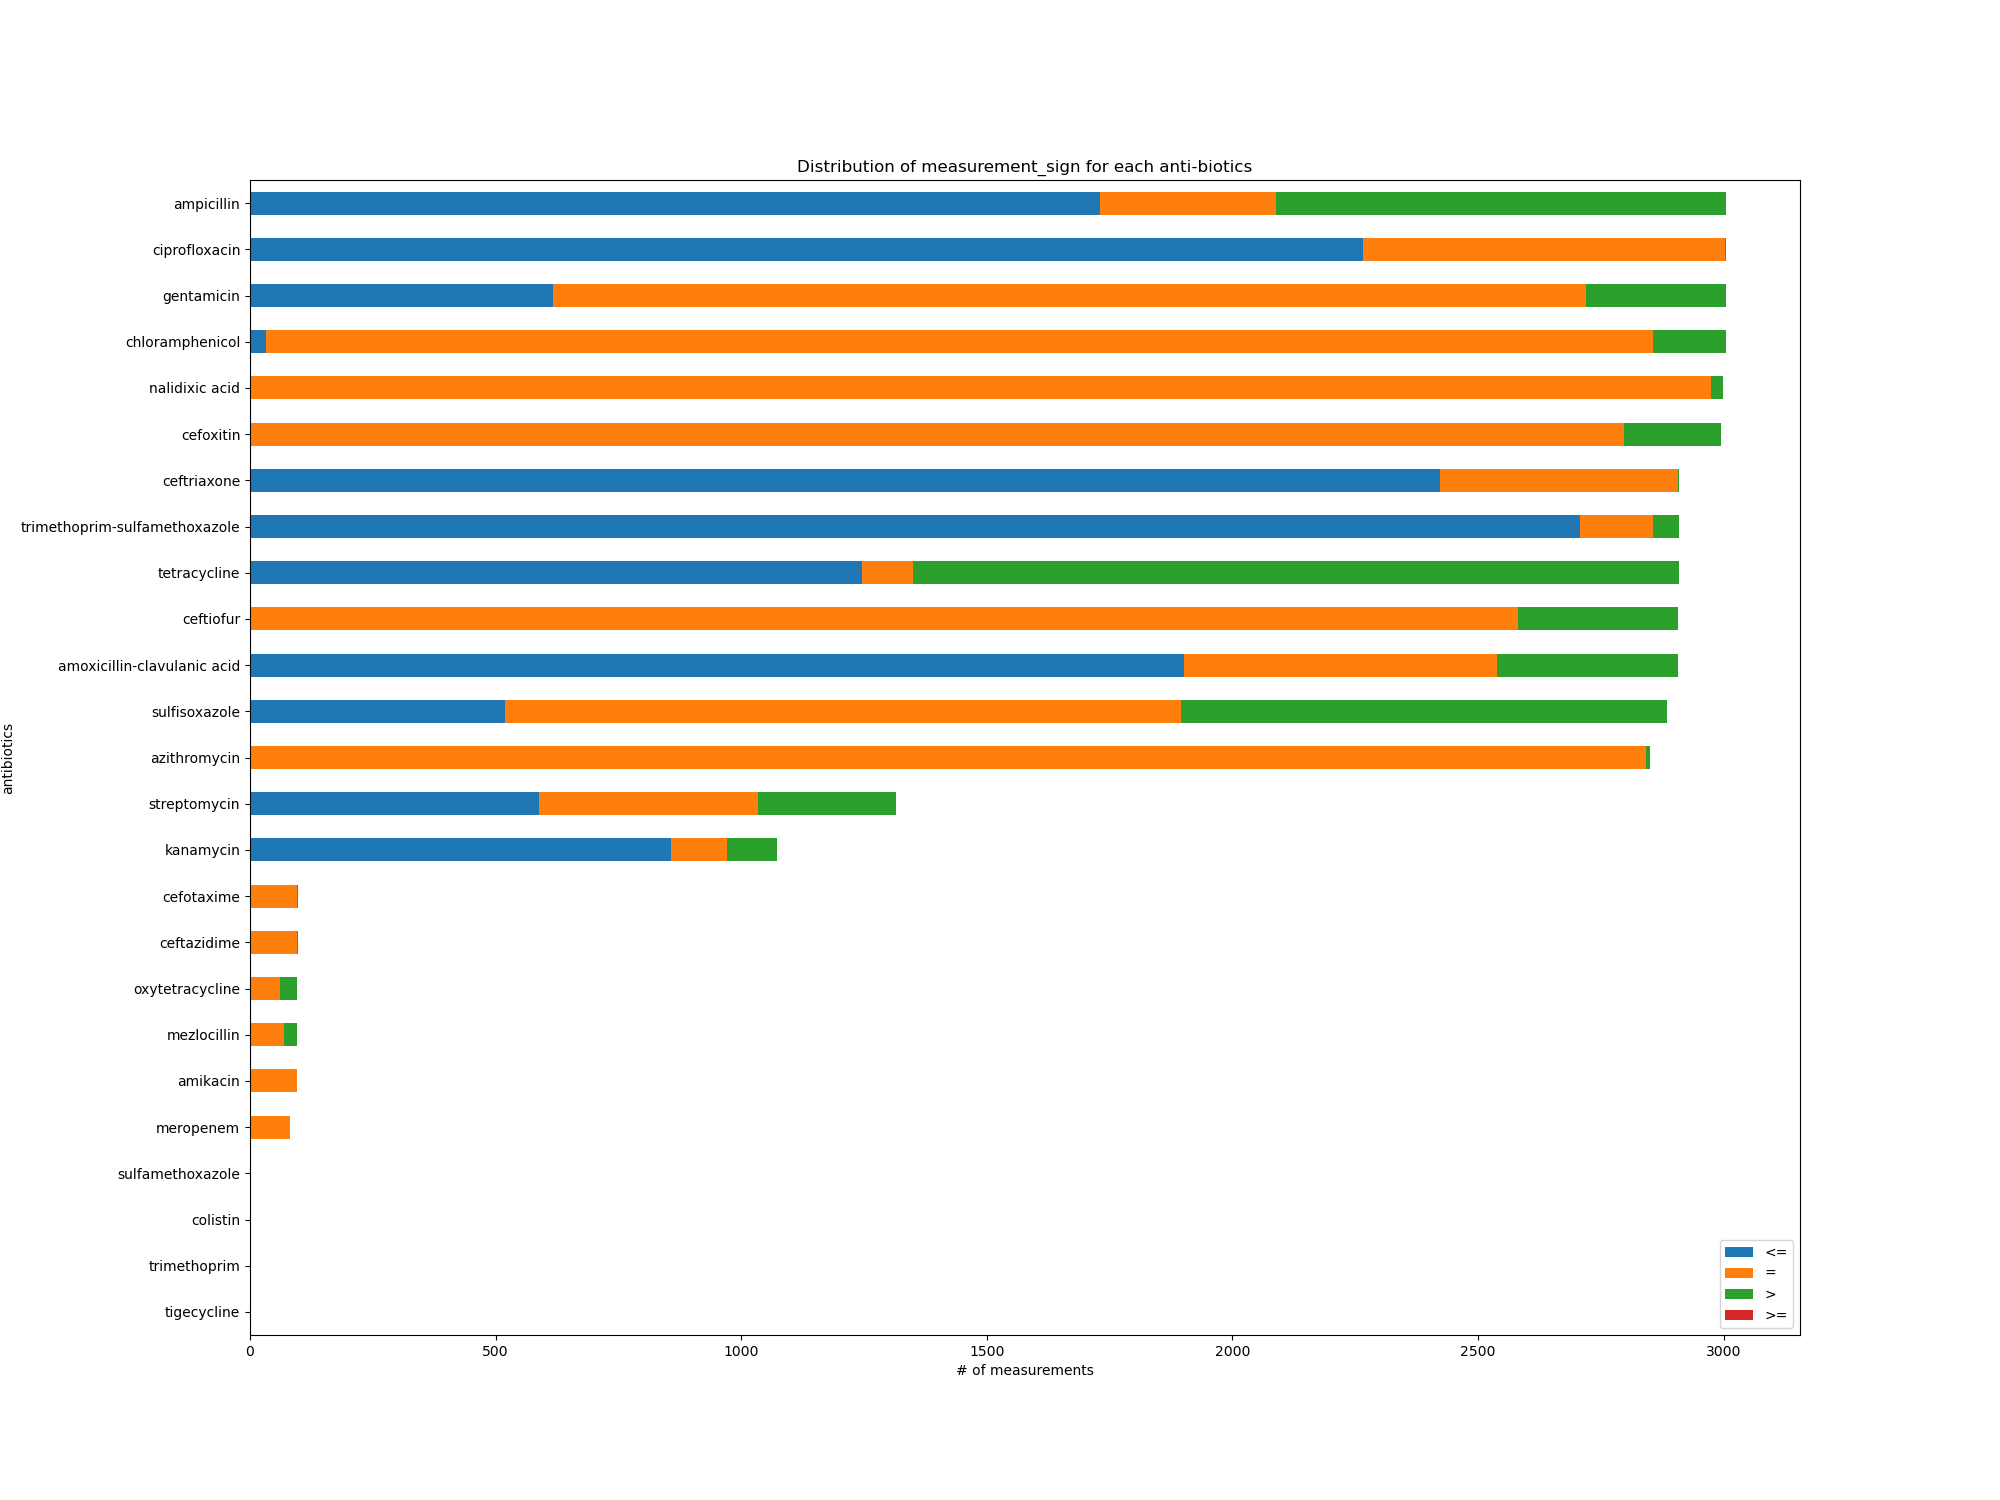

In [15]:
look_at_anti_dist(filtered_ASR, 'measurement_sign', col_order=None)

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


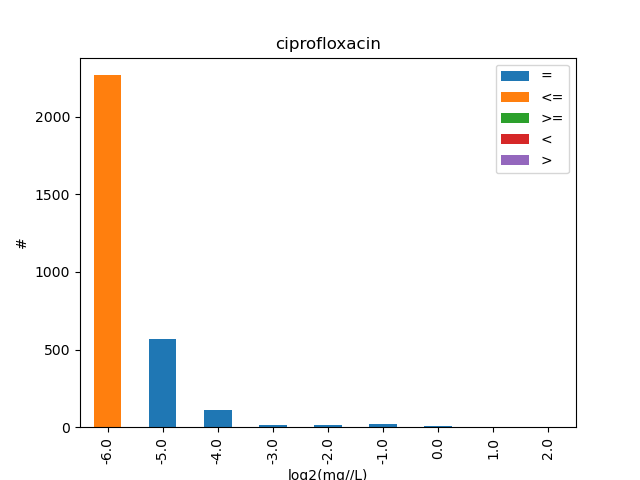

<IPython.core.display.Javascript object>


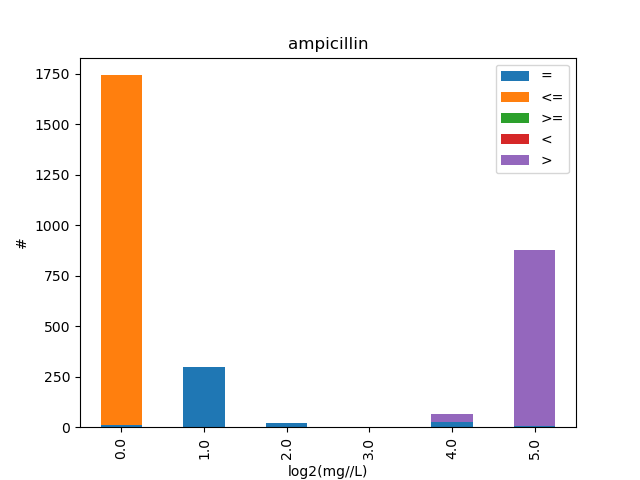

<IPython.core.display.Javascript object>


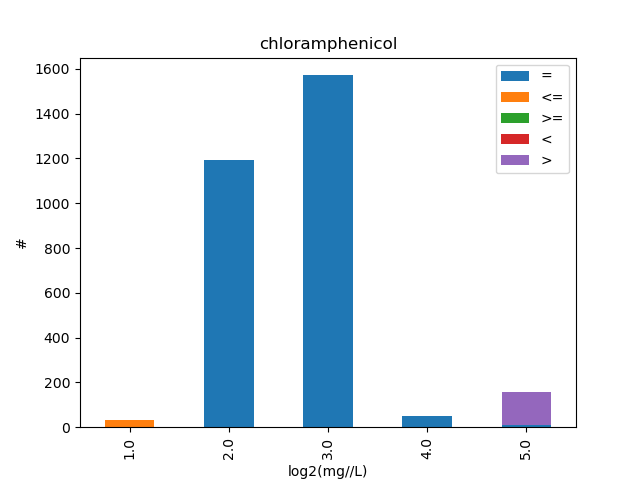

<IPython.core.display.Javascript object>


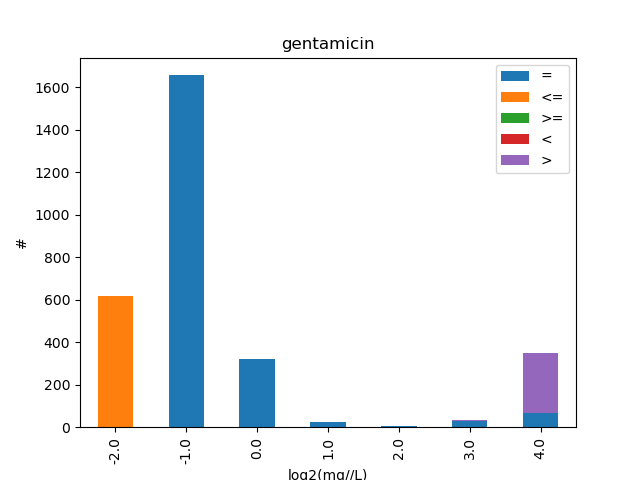

<IPython.core.display.Javascript object>


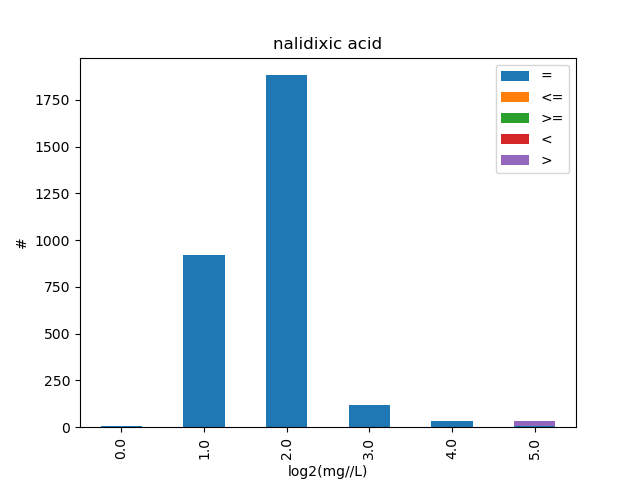

<IPython.core.display.Javascript object>


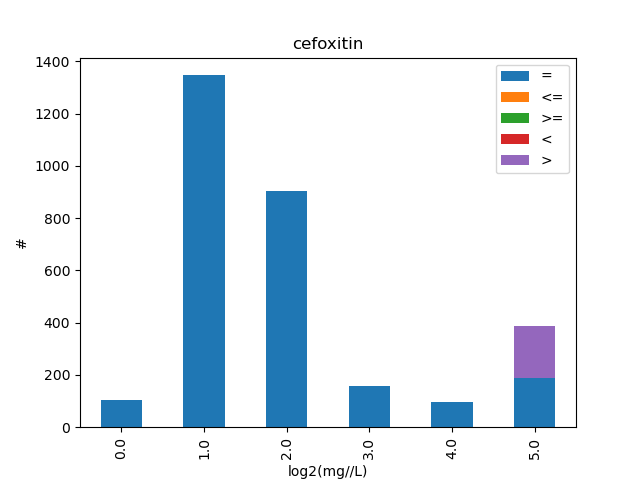

<IPython.core.display.Javascript object>


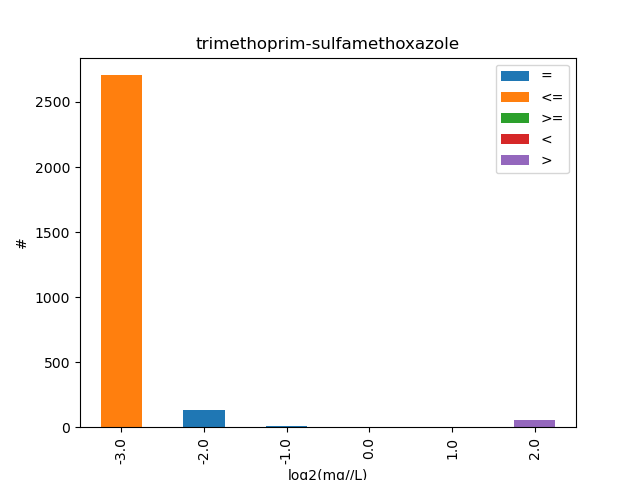

<IPython.core.display.Javascript object>


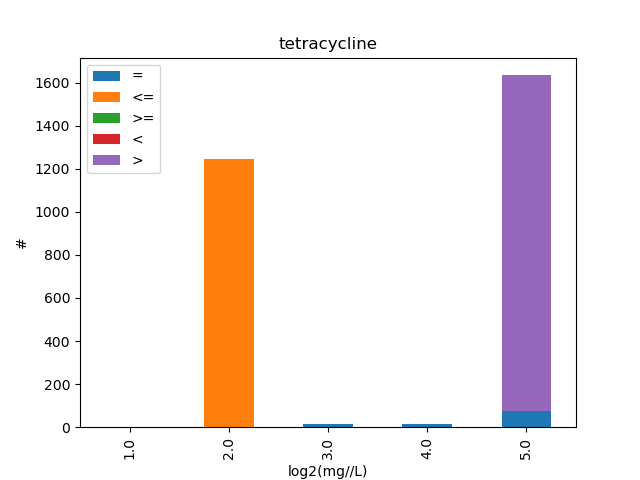

<IPython.core.display.Javascript object>


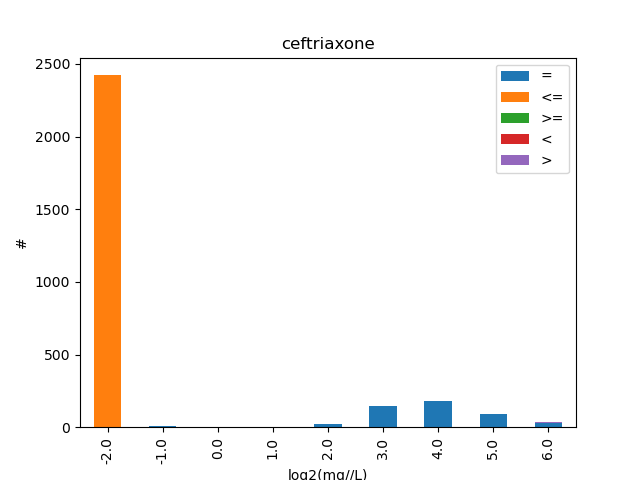

<IPython.core.display.Javascript object>


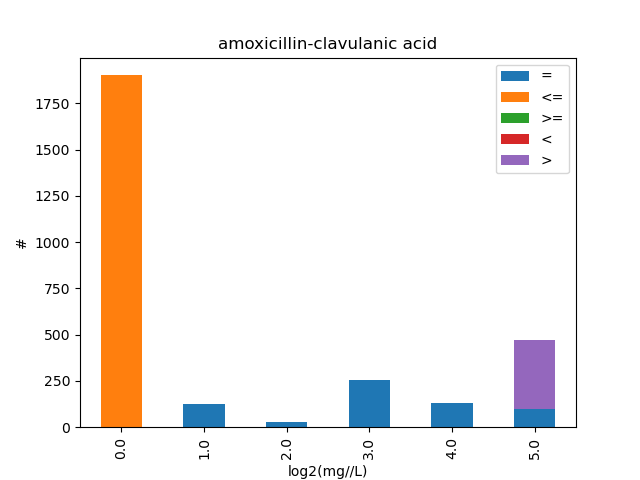

In [16]:
for i in np.arange(10):
    print_anti_measure(filtered_ASR, i)

## list of valid labels:

In [29]:
filtered_ASR['antibiotic_name'].value_counts()

ciprofloxacin                    3005
ampicillin                       3005
chloramphenicol                  3004
gentamicin                       3004
nalidixic acid                   2999
cefoxitin                        2995
trimethoprim-sulfamethoxazole    2908
tetracycline                     2908
ceftriaxone                      2908
amoxicillin-clavulanic acid      2907
ceftiofur                        2907
sulfisoxazole                    2884
azithromycin                     2849
streptomycin                     1316
kanamycin                        1072
ceftazidime                        97
cefotaxime                         97
mezlocillin                        96
amikacin                           96
oxytetracycline                    96
meropenem                          82
sulfamethoxazole                    1
colistin                            1
tigecycline                         1
trimethoprim                        1
Name: antibiotic_name, dtype: int64

In [30]:
anti_list = filtered_ASR['antibiotic_name'].value_counts().index.values

In [31]:
anti_list

array(['ciprofloxacin', 'ampicillin', 'chloramphenicol', 'gentamicin',
       'nalidixic acid', 'cefoxitin', 'trimethoprim-sulfamethoxazole',
       'tetracycline', 'ceftriaxone', 'amoxicillin-clavulanic acid',
       'ceftiofur', 'sulfisoxazole', 'azithromycin', 'streptomycin',
       'kanamycin', 'ceftazidime', 'cefotaxime', 'mezlocillin',
       'amikacin', 'oxytetracycline', 'meropenem', 'sulfamethoxazole',
       'colistin', 'tigecycline', 'trimethoprim'], dtype=object)

In [32]:
filtered_ASR.set_index('unique_id', inplace=True)

## set general data columns

In [33]:
data.set_index('unique_id', inplace=True)

In [34]:
data.columns

Index(['Unnamed: 0', 'species_fam', 'run_id', 'biosample_id', 'nitrofurantoin',
       'piperacillin-tazobactam', 'amikacin', 'cefazolin', 'cefepime',
       'cefoxitin',
       ...
       'vatF->seq_id', 'vatF->seq_cov', 'CTX-M-24->seq_id',
       'CTX-M-24->seq_cov', 'TEM-63->seq_id', 'TEM-63->seq_cov',
       'ACT-22->seq_id', 'ACT-22->seq_cov', 'CTX-M-66->seq_id',
       'CTX-M-66->seq_cov'],
      dtype='object', length=1289)

In [35]:
data.drop(['Unnamed: 0', 'species_fam', 'run_id', 'biosample_id'], axis=1, inplace=True)

In [36]:
data

,nitrofurantoin,piperacillin-tazobactam,amikacin,cefazolin,cefepime,cefoxitin,ceftazidime,ceftriaxone,meropenem,amoxicillin-clavulanic acid,...,vatF->seq_id,vatF->seq_cov,CTX-M-24->seq_id,CTX-M-24->seq_cov,TEM-63->seq_id,TEM-63->seq_cov,ACT-22->seq_id,ACT-22->seq_cov,CTX-M-66->seq_id,CTX-M-66->seq_cov
unique_id,,,,,,,,,,,,,,,,,,,,,
SAMN04229826VAMP,>= 9.0,NaN,<= 4.0,>= 6.0,NaN,>= 6.0,>= 6.0,>= 6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMN04229822VAMP,>= 9.0,NaN,NaN,>= 6.0,NaN,NaN,NaN,>= 6.0,= 1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMN04229823VAMP,>= 9.0,NaN,> 5.0,>= 6.0,NaN,NaN,= 3.0,>= 6.0,= 0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMN04229824VAMP,>= 9.0,NaN,<= 4.0,>= 6.0,NaN,NaN,> 4.0,>= 6.0,= 1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMN04229825VAMP,>= 9.0,NaN,<= 4.0,>= 6.0,NaN,NaN,> 4.0,>= 6.0,= 2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMN02912014PATAKI,NaN,NaN,NaN,NaN,NaN,= 1.0,NaN,<= -2.0,NaN,<= 0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMN02912015PATAKI,NaN,NaN,NaN,NaN,NaN,= 1.0,NaN,<= -2.0,NaN,<= 0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMN05416460PATAKI,NaN,NaN,NaN,NaN,NaN,= 1.0,NaN,<= -2.0,NaN,<= 0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Building models

## order data per label

In [143]:
exp_name = '1_species_and_anti_train_no_train_range_60min'
species_filter_index = 1
antibiotic_index = 0
naive = True
strip_range_train=False
distance_range_train=False
# range_moved=5


In [144]:
X, y, X_range, y_range, features, label = get_filtered_data(
    data = 'tot_filtered_data.csv', 
    features = 'final_features',
    ASR_data = 'filtered_ASR_data.csv', 
    species_sep = True, 
    species_filter_index=species_filter_index, 
    naive=naive, 
    strip_range_train=strip_range_train,
    test_range=True, 
    antibiotic_index=antibiotic_index,
    distance_range_train = distance_range_train,
    range_moved = range_moved,
    task='regression',
)
from sklearn.model_selection import train_test_split
filtered_data = X.merge(y, left_index=True, right_index=True)
train, test = train_test_split(filtered_data, test_size=0.2, random_state=42)
train.to_csv('../resources/train_{}.csv'.format(exp_name))
test.to_csv('../resources/test_{}.csv'.format(exp_name))
X_range.to_csv('../resources/range_{}.csv'.format(exp_name))
y_range.to_csv('../resources/y_range_{}.csv'.format(exp_name))
pd.DataFrame({'features': features}).to_csv('../resources/features_{}.csv'.format(exp_name))
pd.DataFrame({'label': [label]}).to_csv('../resources/label_{}.csv'.format(exp_name))

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: DtypeWarning: Columns (4,5,6,7,8,10,12,15,18,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,1156,1157,1158,1159,1160,1161,1162,1163,1164) have mixed types.Specify dtype option on import or set low_memory=False.
  del sys.path[0]
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  del sys.path[0]


## playing with autoxgb

In [145]:
from autoxgb import AutoXGB

In [146]:
# required parameters:
train_filename = '../resources/train_{}.csv'.format(exp_name)
output = exp_name

# optional parameters
test_filename = '../resources/test_{}.csv'.format(exp_name)
task = 'regression'
idx = 'unique_id'
targets = [y.name]
features = list(X.columns.values)
categorical_features = None
use_gpu = True
num_folds = 5
seed = 42
num_trials = 100
time_limit = 3600
fast = False

# Now its time to train the model!
axgb = AutoXGB(
    train_filename=train_filename,
    output=output,
    test_filename=test_filename,
    task=task,
    idx=idx,
    targets=targets,
    features=features,
    categorical_features=categorical_features,
    use_gpu=use_gpu,
    num_folds=num_folds,
    seed=seed,
    num_trials=num_trials,
    time_limit=time_limit,
    fast=fast,
)
axgb.train()

2022-01-25 19:39:42.201 | INFO     | autoxgb.autoxgb:__post_init__:42 - Output directory: 1_species_and_anti_train_no_train_range_60min
2022-01-25 19:39:42.202 | INFO     | autoxgb.autoxgb:_process_data:149 - Reading training data
2022-01-25 19:39:42.332 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.09 Mb (74.6% reduction)
2022-01-25 19:39:42.332 | INFO     | autoxgb.autoxgb:_determine_problem_type:140 - Problem type: single_column_regression
2022-01-25 19:39:42.442 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 0.02 Mb (74.5% reduction)
2022-01-25 19:39:42.443 | INFO     | autoxgb.autoxgb:_create_folds:58 - Creating folds
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/autoxgb/autoxgb.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get

In [71]:
from autoxgb.cli.predict import PredictAutoXGBCommand
PredictAutoXGBCommand(exp_name, '../resources/range_{}.csv'.format(exp_name), '{}/range_preds.csv'.format(exp_name)).execute()

2022-01-25 14:59:40.394 | INFO     | autoxgb.utils:reduce_memory_usage:50 - Mem. usage decreased to 1.41 Mb (74.8% reduction)


### exact results

In [130]:
label = pd.read_csv('../resources/label_{}.csv'.format(exp_name)).loc[0, 'label']
y_range = pd.read_csv('../resources/y_range_{}.csv'.format(exp_name)).set_index('unique_id')

In [138]:
y = pd.read_csv('../resources/train_{}.csv'.format(exp_name)).set_index('unique_id')[label]
train_res = pd.read_csv('../notebooks/{}/oof_predictions.csv'.format(exp_name)).set_index('unique_id').merge(y, left_index=True, right_index=True, how='inner')
train_res = train_res.loc[set(train_res.index)-set(y_range.index)]
train_res.columns=['y_pred', 'y_true']
train_res['y_true'] = np.round(train_res['y_true'])
min_true = train_res['y_true'].min()
max_true = train_res['y_true'].max(axis=0)
train_res['y_pred'] = train_res['y_pred'].clip(lower=min_true, upper=max_true)
train_res['residual'] = train_res['y_true'] - train_res['y_pred']
train_res['y_pred'] = np.round(train_res['y_pred'])
train_res['round_residual'] = train_res['y_true'] - train_res['y_pred']
train_res.describe()

,y_pred,y_true,residual,round_residual
count,603.000000,603.000000,603.000000,603.000000
mean,-4.880597,-4.592040,0.283693,0.288557
std,0.560913,0.984634,0.802792,0.818993
min,-5.000000,-5.000000,-3.646282,-4.000000
25%,-5.000000,-5.000000,0.000000,0.000000
50%,-5.000000,-5.000000,0.000000,0.000000
75%,-5.000000,-5.000000,0.000000,0.000000
max,1.000000,1.000000,5.000000,5.000000


In [139]:
y = pd.read_csv('../resources/test_{}.csv'.format(exp_name)).set_index('unique_id')[label]
test_res = pd.read_csv('../notebooks/{}/test_predictions.csv'.format(exp_name)).set_index('unique_id').merge(y, left_index=True, right_index=True, how='inner')
test_res = test_res.loc[set(test_res.index)-set(y_range.index)]
test_res.columns=['y_pred', 'y_true']
test_res['y_true'] = np.round(test_res['y_true'])
min_true = test_res['y_true'].min()
max_true = test_res['y_true'].max(axis=0)
test_res['y_pred'] = test_res['y_pred'].clip(lower=min_true, upper=max_true)
test_res['residual'] = test_res['y_true'] - test_res['y_pred']
test_res['y_pred'] = np.round(test_res['y_pred'])
test_res['round_residual'] = test_res['y_true'] - test_res['y_pred']
test_res.describe()

,y_pred,y_true,residual,round_residual
count,133.000000,133.000000,133.000000,133.000000
mean,-5.639098,-4.526316,1.144141,1.112782
std,0.607258,1.132033,0.907370,0.982068
min,-6.000000,-6.000000,0.000000,0.000000
25%,-6.000000,-5.000000,1.000000,1.000000
50%,-6.000000,-5.000000,1.000000,1.000000
75%,-5.000000,-5.000000,1.000000,1.000000
max,-3.000000,1.000000,5.735569,6.000000


In [140]:
regression_res = pd.DataFrame({
    'exact RMSE': [train_res['residual'].std(), test_res['residual'].std()],
    'exact_rounded RMSE': [train_res['round_residual'].std(), test_res['round_residual'].std()],
}, index=['train', 'test'])
regression_res

,exact RMSE,exact_rounded RMSE
train,0.802792,0.818993
test,0.907370,0.982068


<IPython.core.display.Javascript object>


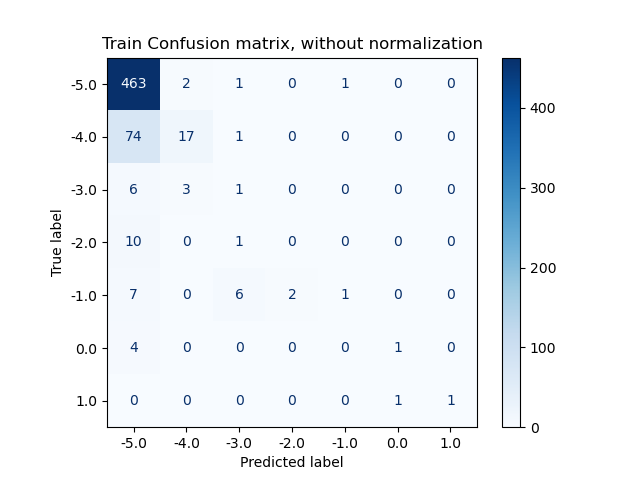

<IPython.core.display.Javascript object>


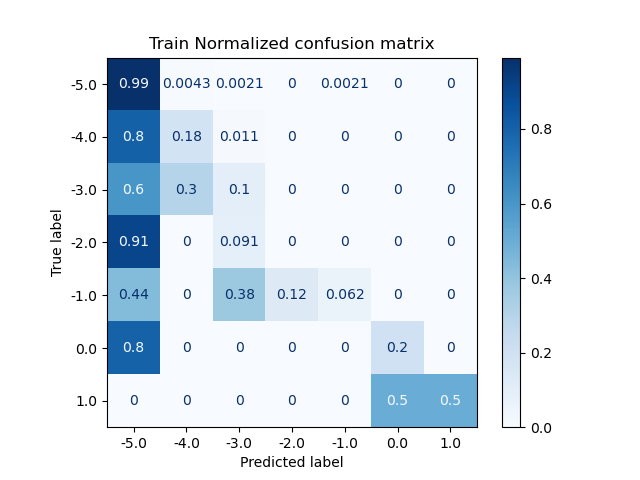

<IPython.core.display.Javascript object>


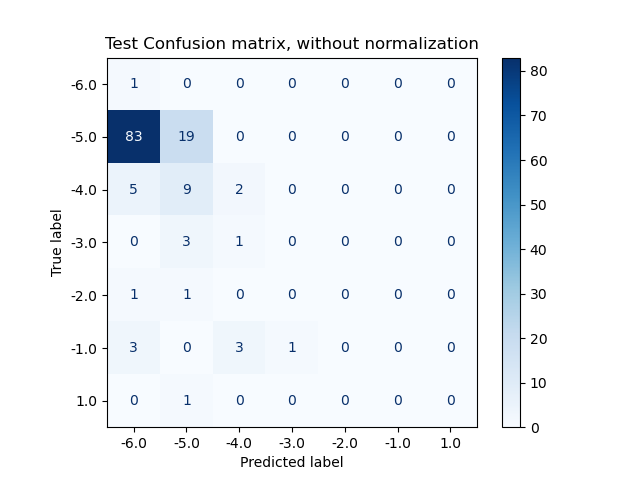

<IPython.core.display.Javascript object>


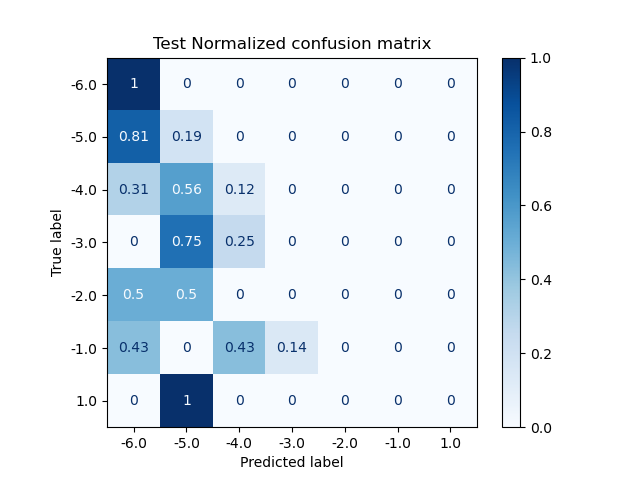

In [142]:
for key, res in {'Train': train_res, 'Test': test_res}.items():
    titles_options = [
        (key+ " Confusion matrix, without normalization", None),
        (key+" Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_predictions(
            np.round(res['y_true']),
            res['y_pred'],
            labels=np.sort(list(set(list(np.round(res['y_true']).unique())).union(set(list(np.round(res['y_pred']).unique()))))),
    #         display_labels=np.sort(list(train_res['y_true'].unique())),
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)
        cm = pd.DataFrame(disp.confusion_matrix, index=disp.display_labels, columns=disp.display_labels)
        cm.columns.name='predicted_labels'
        cm.index.name='true_labels'
        cm.to_csv('../notebooks/{}/{}_df_confusion_matrix_{}.csv'.format(exp_name, key, normalize))
        plt.savefig('../notebooks/{}/{}_confusion_matrix_{}.png'.format(exp_name, key, normalize), format='png')
plt.show()

### range result

In [77]:
equal_meaning = True

In [78]:
range_res = pd.read_csv('../notebooks/{}/range_preds.csv'.format(exp_name)).set_index('unique_id').merge(y_range, left_index=True, right_index=True, how='inner')
range_res.columns=['y_pred'] + list(range_res.columns.values)[1:]
range_res['values'] = np.round(range_res['values'])
range_res['updated_values'] = np.nan
range_res['updated_direction'] = np.nan
if equal_meaning:
        range_res.loc[range_res['direction'] == '>=','updated_values'] = range_res['values'] - 1
        range_res.loc[range_res['direction'] == '<=','updated_values'] = range_res['values'] + 1
range_res.loc[range_res['direction'] == '>=','updated_direction'] = '>'
range_res.loc[range_res['direction'] == '<=','updated_direction'] = '<'

range_res.loc[:,'updated_values'].fillna(range_res['values'], inplace=True)
range_res.loc[:,'updated_direction'].fillna(range_res['direction'], inplace=True)

range_res.loc[range_res['updated_direction'] == '>','answer'] = (range_res['y_pred'] > range_res['updated_values'])
range_res.loc[range_res['updated_direction'] == '<','answer'] = (range_res['y_pred'] < range_res['updated_values'])
train_range_res = range_res.loc[set(range_res.index).intersection(set(train.index))]
test_range_res = range_res.loc[set(range_res.index) - set(train.index)]
for key, res in {'train': train_range_res, 'test': test_range_res}.items():
    range_confusion = res.groupby(by=['direction', 'values'])['answer'].agg(['count', 'sum']).replace(True, 1)
    range_confusion['perc'] = range_confusion['sum'] / range_confusion['count']
    range_confusion.columns = ['total', 'in range', 'accuracy']
    range_confusion = pd.DataFrame(range_confusion.stack()).T.swaplevel(i=2, j=0, axis=1)
    range_confusion.index=[key]
    regression_res = pd.concat([regression_res, range_confusion], axis=1)

In [79]:
regression_res_cleaned = pd.DataFrame({})
for col in regression_res.columns:
    if len(regression_res[[col]].columns) > 1:
        regression_res_cleaned[col] = regression_res[[col]].iloc[:,0].fillna(regression_res[[col]].iloc[:,1])
    else:
        regression_res_cleaned[col] = regression_res[[col]]
regression_res = regression_res_cleaned

In [80]:
regression_res

,exact RMSE,exact_rounded RMSE,"(total, -6.0, <)","(in range, -6.0, <)","(accuracy, -6.0, <)","(total, 2.0, >)","(in range, 2.0, >)","(accuracy, 2.0, >)"
train,2.135843,2.164767,1799,1792,0.996109,2,2,1.0
test,2.115381,2.155899,467,458,0.980728,1,False,0.0


In [81]:
regression_res.to_csv('../notebooks/{}/df_regression_results.csv'.format(exp_name))

In [83]:
label

'ciprofloxacin'

## Playing with h2o

In [106]:
filtered_data.head()

,tet(C)->seq_id,eptA->seq_id,TEM-206->seq_cov,Nocardia_rifampin_resistant_beta-subunit_of_RNA_polymerase_(rpoB2)->seq_id,dfrA16->seq_id,sdiA->seq_id,SHV-134->seq_cov,CTX-M-55->seq_cov,AAC(3)-VIa->seq_id,SHV-134->seq_id,...,msrE->seq_id,ugd->seq_cov,Klebsiella_pneumoniae_KpnF->seq_cov,aadA7->seq_cov,aadA12->seq_cov,Escherichia_coli_ampH->seq_cov,EreA2->seq_id,QnrA1->seq_cov,baeR->seq_id,ciprofloxacin
unique_id,,,,,,,,,,,,,,,,,,,,,
SAMN05771806PATAKI,0.0,76.97,0.0,75.33,0.0,100.00,0.0,0.0,0.0,0.0,...,0.0,99.83,99.7,0.0,0.0,100.0,0.0,0.0,81.72,-6.058894
SAMN05771805PATAKI,0.0,76.97,0.0,75.33,0.0,100.00,0.0,0.0,0.0,0.0,...,0.0,99.83,99.7,0.0,0.0,100.0,0.0,0.0,81.72,-6.058894
SAMN05771804PATAKI,0.0,76.97,0.0,75.33,0.0,100.00,0.0,0.0,0.0,0.0,...,0.0,99.83,99.7,0.0,0.0,100.0,0.0,0.0,81.72,-6.058894
SAMN05771803PATAKI,0.0,76.97,0.0,75.33,0.0,100.00,0.0,0.0,0.0,0.0,...,0.0,99.83,99.7,0.0,0.0,100.0,0.0,0.0,81.72,-6.058894
SAMN05771802PATAKI,0.0,77.16,0.0,75.58,0.0,98.75,0.0,0.0,0.0,0.0,...,0.0,99.83,99.7,0.0,0.0,100.0,0.0,0.0,81.58,-6.058894


In [107]:
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
trainH2o = h2o.import_file('../resources/train_{}_naive.csv'.format(y.name))
testH2o = h2o.import_file('../resources/test_{}_naive.csv'.format(y.name))

# Identify predictors and response
x = features
y = label

# Run AutoML for 20 base models
aml = H2OAutoML(max_models=100, seed=1, max_runtime_secs=86400)
aml.train(x=x, y=y, training_frame=trainH2o)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# model_id                                                  auc    logloss    mean_per_class_error      rmse       mse
# ---------------------------------------------------  --------  ---------  ----------------------  --------  --------
# StackedEnsemble_AllModels_AutoML_20181212_105540     0.789801   0.551109                0.333174  0.43211   0.186719
# StackedEnsemble_BestOfFamily_AutoML_20181212_105540  0.788425   0.552145                0.323192  0.432625  0.187165
# XGBoost_1_AutoML_20181212_105540                     0.784651   0.55753                 0.325471  0.434949  0.189181
# XGBoost_grid_1_AutoML_20181212_105540_model_4        0.783523   0.557854                0.318819  0.435249  0.189441
# XGBoost_grid_1_AutoML_20181212_105540_model_3        0.783004   0.559613                0.325081  0.435708  0.189841
# XGBoost_2_AutoML_20181212_105540                     0.78136    0.55888                 0.347074  0.435907  0.190015
# XGBoost_3_AutoML_20181212_105540                     0.780847   0.559589                0.330739  0.43613   0.190209
# GBM_5_AutoML_20181212_105540                         0.780837   0.559903                0.340848  0.436191  0.190263
# GBM_2_AutoML_20181212_105540                         0.780036   0.559806                0.339926  0.436415  0.190458
# GBM_1_AutoML_20181212_105540                         0.779827   0.560857                0.335096  0.436616  0.190633
# GBM_3_AutoML_20181212_105540                         0.778669   0.56179                 0.325538  0.437189  0.191134
# XGBoost_grid_1_AutoML_20181212_105540_model_2        0.774411   0.575017                0.322811  0.4427    0.195984
# GBM_4_AutoML_20181212_105540                         0.771426   0.569712                0.33742   0.44107   0.194543
# GBM_grid_1_AutoML_20181212_105540_model_1            0.769752   0.572583                0.344331  0.442452  0.195764
# GBM_grid_1_AutoML_20181212_105540_model_2            0.754366   0.918567                0.355855  0.496638  0.246649
# DRF_1_AutoML_20181212_105540                         0.742892   0.595883                0.355403  0.452774  0.205004
# XRT_1_AutoML_20181212_105540                         0.742091   0.599346                0.356583  0.453117  0.205315
# DeepLearning_grid_1_AutoML_20181212_105540_model_2   0.741795   0.601497                0.368291  0.454904  0.206937
# XGBoost_grid_1_AutoML_20181212_105540_model_1        0.693554   0.620702                0.40588   0.465791  0.216961
# DeepLearning_1_AutoML_20181212_105540                0.69137    0.637954                0.409351  0.47178   0.222576
# DeepLearning_grid_1_AutoML_20181212_105540_model_1   0.690084   0.661794                0.418469  0.476635  0.227181
# GLM_grid_1_AutoML_20181212_105540_model_1            0.682648   0.63852                 0.397234  0.472683  0.223429
#
# [22 rows x 6 columns]

# The leader model is stored here
aml.leader

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 min 10 secs
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.1
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_amitdanw_auth_ad_bgu_ac_il_bd4fw5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.200 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
23:23:59.206: _train param, Dropping bad and constant columns: [AAC(3)-IIb->seq_cov, dfrA5->seq_cov, AAC(6')-IIc->seq_cov, AAC(3)-IIb->seq_id, dfrA5->seq_id, EreA2->seq_cov, Klebsiella_pneumoniae_KpnH->seq_id, Escherichia_coli_acrA->seq_cov, catII_from_Escherichia_coli_K-12->seq_cov, EreA2->seq_id, Klebsiella_pneumoniae_KpnH->seq_cov, AAC(6')-IIc->seq_id, LAP-2->seq_id, catII_from_Escherichia_coli_K-12->seq_id, LAP-2->seq_cov]

██
23:24:06.254: _train param, Dropping bad and constant columns: [AAC(3)-IIb->seq_cov, dfrA5->seq_cov, AAC(6')-IIc->seq_cov, AAC(3)-IIb->seq_id, dfrA5->seq_id, EreA2->seq_cov, Klebsiella_pneumoniae_KpnH->seq_id, Escherichia_coli_acrA->seq_cov, catII_from_Escherichia_coli_K-12->seq_cov, EreA2->seq_id, Klebsiella_pneumoniae_KpnH->seq_cov, AAC(6')-IIc->seq_id

In [ ]:
preds = aml.predict(testH2o)

## Playing with Amoxicillin - Clavulanic acid as regression

In [223]:
X = filtered_data[features]
y = filtered_data[best_label+'_filtered']

In [226]:
kf = KFold(n_splits=10, shuffle=True, random_state=rng)

In [228]:
tot_actuals = []
tot_predictions = []
tot_rounded_predictions = []
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(n_jobs=1, tree_method='gpu_hist', gpu_id=0).fit(X.iloc[train_index], y.iloc[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    rounded_predictions = [min(final_dict.values(), key=lambda x:abs(x-pred)) for pred in predictions]
    print("rounded: ", rounded_predictions)
    print("actual: ", actuals.T[0])
    print(mean_squared_error(actuals, predictions))
    print(confusion_matrix([str(x) for x in actuals.T[0]], [str(x) for x in rounded_predictions]))
    tot_actuals += list(actuals.T[0])
    tot_rounded_predictions += rounded_predictions
    tot_predictions += list(predictions)

XGBoostError: [11:31:40] /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/gbm/../common/common.h:157: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1a393b) [0x7f992193f93b]
  [bt] (1) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1a39cc) [0x7f992193f9cc]
  [bt] (2) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(xgboost::gbm::GBTree::ConfigureUpdaters()+0xa5) [0x7f992193fa85]
  [bt] (3) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(xgboost::gbm::GBTree::Configure(std::vector<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&)+0x309) [0x7f9921956039]
  [bt] (4) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1e67fd) [0x7f99219827fd]
  [bt] (5) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1d5787) [0x7f9921971787]
  [bt] (6) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(XGBoosterUpdateOneIter+0x4c) [0x7f9921855abc]
  [bt] (7) /home/amitdanw/.conda/envs/gps/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f999bbf1a4a]
  [bt] (8) /home/amitdanw/.conda/envs/gps/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f999bbf0fea]



In [291]:
print(mean_squared_error(tot_actuals, tot_predictions))

0.7742366563759465


<IPython.core.display.Javascript object>


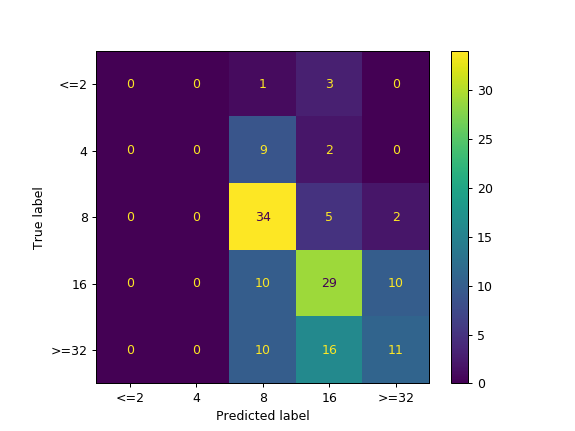

In [292]:
cm = confusion_matrix(
    [str(x) for x in tot_actuals], 
    [str(x) for x in tot_rounded_predictions], 
    labels=[str(x) for x in final_dict.values()],
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(x) for x in final_dict.keys()],
)
disp.plot() 

### run Parameter Opt

In [319]:
param_grid = {
    'max_depth':[3, 4, 6, 8, 10], 
    'n_estimators': [20, 50, 100, 200],
    'eta': uniform(loc=0, scale=1),
    'gamma': uniform(loc=0, scale=100),
    'min_child_weight': uniform(loc=0, scale=10),
    ''
}

In [320]:
xgb_model = xgb.XGBRegressor(n_jobs=1, tree_method='gpu_hist', gpu_id=0)

In [321]:
kf = KFold(n_splits=10, shuffle=True, random_state=rng)

In [322]:
clf = RandomizedSearchCV(xgb_model, param_distributions=param_grid, random_state=rng, cv = kf)

In [323]:
search = clf.fit(X, y)
search.best_params_
search.best_score_

[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

0.2719582886878314

[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

<IPython.core.display.Javascript object>


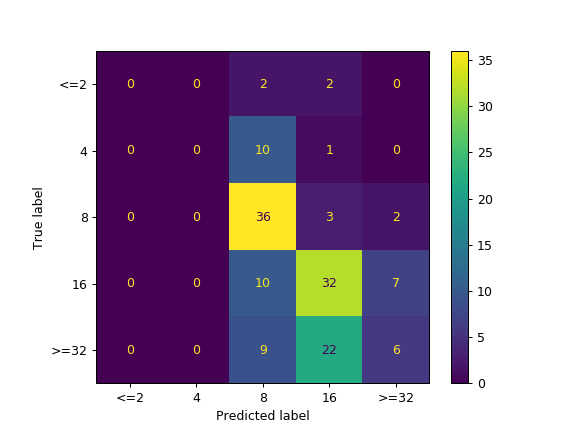

In [324]:
tot_actuals = []
tot_predictions = []
tot_rounded_predictions = []
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(n_jobs=1, **search.best_params_).fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    rounded_predictions = [min(final_dict.values(), key=lambda x:abs(x-pred)) for pred in predictions]
    tot_actuals += list(actuals.T[0])
    tot_rounded_predictions += rounded_predictions
    tot_predictions += list(predictions)
    
print(mean_squared_error(tot_actuals, tot_predictions))
cm = confusion_matrix(
    [str(x) for x in tot_actuals], 
    [str(x) for x in tot_rounded_predictions], 
    labels=[str(x) for x in final_dict.values()],
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(x) for x in final_dict.keys()],
)
disp.plot() 

In [318]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)